# GLM Demo: univariate stimulus, biophysical dynamics

This is a testing notebook for the GLM estimation algorithm. We simulate data using the biocm dynamical cascade model, and then try to estimate parameters with the GLM model. The GLM model does not have a membrane, so the estimated RF should be the convolution of the input kernel ($k1$) with the membrane kernel ($k2$) which is approximately an exponential decay with time constant $\tau_m$. 

In [ ]:
from __future__ import print_function, division
import os
import numpy as np
import scipy as sp
import scipy.signal as sps
import quickspikes as qs

import mat_neuron._model as mat
from dstrf import strf, mle
import spyks.core as spkc

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

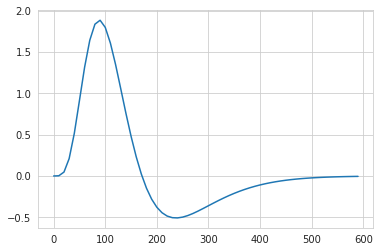

In [2]:
ataus = np.asarray([10, 200], dtype='d')
model_dt = 0.5

# convolution kernel
from dstrf import filters
stim_dt = 10.0
kscale = 1.0
ntau = 60
upsample = int(stim_dt / model_dt)
k1, kt = filters.gammadiff(ntau * stim_dt / 32, ntau * stim_dt / 16, 5 * kscale, ntau * stim_dt, stim_dt)
#k1, kt = filters.exponential(ntau * stim_dt / 4, 500 * kscale, ntau * stim_dt, stim_dt)
plt.plot(kt, k1);

## Generate the stimulus and the response

Also using white noise here.

In [3]:
# generating spikes with biocm
model_name = "biocm_phasic.yml"
current_scaling = 20.0 # this needs to be adjusted on a per model basis. posp ~ 2.0; phasic ~ 10
trial_noise_sd = 1.0
spike_thresh = -20
dt_rise_time = int(1.0 / model_dt)
modelpath = "../../models"
pymodel = spkc.load_model(os.path.join(modelpath, model_name))
biocm_params = spkc.to_array(pymodel["parameters"])
biocm_state0 = spkc.to_array(pymodel["state"])
biocm_model = spkc.load_module(pymodel, modelpath)
    
def filter_stimulus(S, k1):
    return np.convolve(S, k1, mode="full")[:S.size]

def generate_spikes(I, noise_sd, dt, upsample):
    from scipy.signal import resample
    I_noise = np.random.randn(I.size) * noise_sd
    I = current_scaling * (I + I_noise)
    #I_resamp = sps.resample(I + I_noise, I.size * upsample)
    X = biocm_model.integrate(biocm_params, biocm_state0, I, stim_dt, model_dt)
    det = qs.detector(spike_thresh, dt_rise_time)
    return X[:, 0], det(X[:, 0])

In [9]:
# data parameters
duration = 100000
n_bins = int(duration / model_dt)
n_frames = n_bins // upsample
n_assim = 1
n_test = 5

# generate data to fit
np.random.seed(1)
mat.random_seed(1)
data = []
stim = np.random.randn(n_frames)
        
I = filter_stimulus(stim, k1)
for i in range(n_assim + n_test):
    V, spike_t = generate_spikes(I, trial_noise_sd, model_dt, upsample)
    spike_v = np.zeros(V.size, 'i')
    spike_v[spike_t] = 1
    H = mat.adaptation(spike_v, ataus, model_dt)
    d = {"H": H,
         "duration": duration,
         "spike_t": np.asarray(spike_t), 
         "spike_v": spike_v,
        }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


spikes: 138.5; rate: 0.001385 / dt


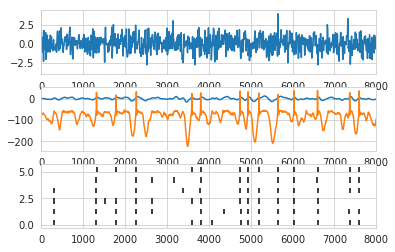

In [7]:
t_stim = np.linspace(0, duration, stim.size)
t_voltage = np.linspace(0, duration, V.size)
plt.subplot(311).plot(t_stim, stim)
plt.subplot(312).plot(t_stim, I, t_voltage, V)
ax2 = plt.subplot(313)
for i, d in enumerate(data):
    ax2.vlines(d["spike_t"] * model_dt, i, i + 0.5)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 8000)
print("spikes: {}; rate: {} / dt".format(np.mean([d["spike_t"].size for d in data]), 
                                         np.mean([d["spike_t"].size / d["duration"] for d in data])))

### Estimation

In [ ]:
from theano import config
import scipy.optimize as op

# cosine basis set
kcosbas = strf.cosbasis(ntau, 10)
kcosbas = ntau

ftype = config.floatX
# combine the trials
spike_v = np.stack([d["spike_v"] for d in assim_data], axis=1)
# spikes in the exponential basis set
X_spikes = np.stack([d["H"] for d in assim_data], axis=2).astype(ftype)
# generate design matrix for stimulus
X_stim = strf.lagged_matrix(stim, kcosbas)
# "correct" strf from current
stx = np.dot(X_stim.T, I) / I.size / stim.var()
# initial guess of strf from sta
sta = strf.correlate(X_stim, spike_v)

plt.plot(k1)
plt.plot(strf.from_basis(stx, kcosbas)[::-1])
plt.plot(strf.from_basis(sta, kcosbas)[::-1])

In [ ]:
from theano import function, config, shared, sparse, gradient
import theano.tensor as T
from theano.tensor import nnet
import scipy.sparse as sps

# the nonlinearity:
nlin = T.exp

if X_spikes.ndim == 2:
    spike_design = np.expand_dims(X_spikes, 2)

nframes, nk = X_stim.shape
nbins, nalpha, ntrials = X_spikes.shape
upsample = int(stim_dt / model_dt)
# make an interpolation matrix
interp = sps.kron(sps.eye(nframes),
                  np.ones((upsample, 1), dtype=config.floatX),
                  format='csc')


# load the data into theano.shared structures
M = shared(interp)
dt = shared(model_dt)
Xstim = shared(X_stim)
Xspke = shared(np.rollaxis(X_spikes, 2))
spikes = sps.csc_matrix(spike_v)
Yspke = shared(spikes)

# split out the parameter vector
w = T.vector('w')
dc = w[0]
h = w[1:(nalpha+1)]
k = w[(nalpha+1):]
Vx = T.dot(Xstim, k)
# Vx has to be promoted to a matrix for structured_dot to work
Vi = sparse.structured_dot(M, T.shape_padright(Vx))
H = T.dot(Xspke, h).T
mu = Vi - H - dc
lmb = nlin(mu)
# this version of the log-likelihood is faster, but the gradient doesn't work
llf = lmb.sum() * dt - sparse.sp_sum(sparse.structured_log(Yspke * lmb), sparse_grad=True)
# this version has a working gradient
ll = lmb.sum() * dt - sparse.sp_sum(Yspke * T.log(lmb), sparse_grad=True)
# this is a penalty to keep the model out of the unallowed space
penalty = - (h[0] + h[1] * matparams[3] / matparams[4])
dL = T.grad(ll, w)
# arbitrary vector for hessian-vector product
v = T.vector('v')
ddLv = T.grad(T.sum(dL * v), w)

fV = function([w], Vx)
fH = function([w], H)
fL = function([w], llf)
fgrad = function([w], dL)
fhess = function([w, v], ddLv)

In [ ]:
# initial likelihood
meanrate = spikes.sum(0).mean() / nbins
w0 = np.r_[np.exp(meanrate), 0, 0, np.zeros_like(sta)]
fL(w0)

In [ ]:
%%time
w_ml = op.fmin_ncg(fL, w0, fgrad, fhess_p=fhess, avextol=1e-6, maxiter=200)

In [ ]:
print(w_ml[:3])
plt.plot(k1)
# expected kernel is the convolution of k1 and k2
# k2 = 
# kconv = np.convolve(k1, k2[::int(stim_dt / model_dt)], mode="full")[:k1.size]
# plt.plot(kconv * k1.max() / kconv.max())
kest = strf.from_basis(w_ml[3:], kcosbas)[::-1]
kest *= k1.max() / kest.max()
plt.plot(kest)

In [ ]:
for ff in (k1, kest):
    K = np.fft.fft(ff)
    plt.plot(np.absolute(K[:K.size//2]))

In [ ]:
# posterior predictive distribution

def predict_spikes_current(I, params, dt, upsample):
    state = mat.voltage(I, fullmatparams, dt, upsample=upsample)
    V = state[:, 0]
    return V, predict_spikes_voltage(V, params, dt, 1)

def predict_spikes_voltage(V, params, dt, upsample):
    omega, a1, a2, t1, t2, tref = params
    return mat.predict_poisson(V - omega, (a1, a2), (t1, t2), tref, dt, upsample)

for j, d in enumerate(test_data):
    plt.vlines(d["spike_t"], j, j + 0.5, 'r')

mparamp = matparams.copy()    
for i in range(n_test):
    V = fV(w_ml)
    mparamp[:3] = w_ml[:3]
    S = predict_spikes_voltage(V, mparamp, model_dt, upsample)
    spk_t = S.nonzero()[0]
    plt.vlines(spk_t, i + j + 1, i + j + 1.5)

plt.xlim(0, 10000)

In [ ]:
# fit to a subset of the data. Need to update shared variables.
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)
i_frames = np.arange(nframes)
i_bins = np.arange(nbins)
ftrain, ftest = next(kf.split(i_frames))
strain, stest = next(kf.split(i_bins))

M.set_value(interp[strain][:, ftrain])
Xstim.set_value(X_stim[ftrain])
Xspke.set_value(np.rollaxis(X_spikes[strain], 2))
Yspke.set_value(spikes[strain])

In [ ]:
%%time
w_ml = op.fmin_ncg(fL, w0, fgrad, fhess_p=fhess, avextol=1e-6, maxiter=200)

In [ ]:
M.set_value(interp[stest][:, ftest])
Xstim.set_value(X_stim[ftest])
Xspke.set_value(np.rollaxis(X_spikes[ftest], 2))
Yspke.set_value(spikes[ftest])